# PS2-Jiayi Jiang

[![Binder](https://mybinder.org/badge_logo.svg)](
https://mybinder.org/v2/git/https%3A%2F%2Fgithub.com%2Fjiayiarch%2FECON502/main?urlpath=%2Fdoc%2Ftree%2FPS2-Jiayi.ipynb)

# 1. Function Intersection

Solution found from initial guess [0.5, 0.5]: (x, y) = (0.7071067811865474, 0.7071067811865474)
Solution found from initial guess [-0.5, -0.5]: (x, y) = (-0.7071067811865474, -0.7071067811865474)


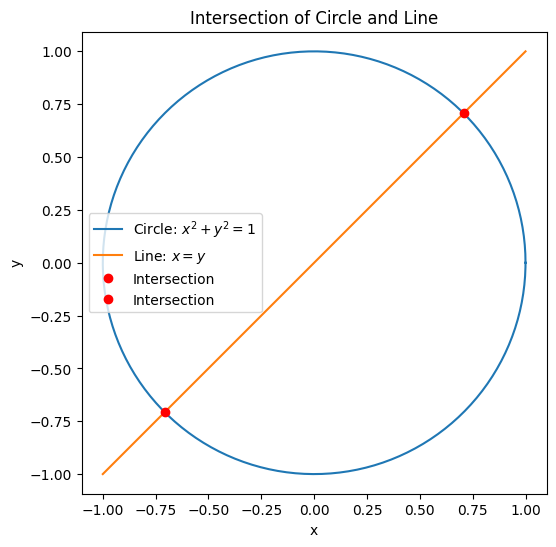

In [34]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

# Define the system of equations:
# f1(x, y) = x^2 + y^2 - 1 = 0
# f2(x, y) = x - y = 0
def system(vars):
    x, y = vars
    return [
        x**2 + y**2 - 1,  
        x - y            
    ]

initial_guesses = [
    [0.5, 0.5],
    [-0.5, -0.5]
]

solutions = []
for guess in initial_guesses:
    sol = root(system, guess)
    if sol.success:
        
        x_sol, y_sol = sol.x
        solutions.append((x_sol, y_sol))
        print(f"Solution found from initial guess {guess}: (x, y) = ({x_sol}, {y_sol})")
    else:
        print(f"Root-finding did not converge for guess {guess}")


theta = np.linspace(0, 2*np.pi, 300)
x_circle = np.cos(theta)
y_circle = np.sin(theta)


x_line = np.linspace(-1, 1, 300)
y_line = x_line  # because x = y

plt.figure(figsize=(6, 6))
plt.plot(x_circle, y_circle, label=r'Circle: $x^2 + y^2 = 1$')
plt.plot(x_line, y_line, label=r'Line: $x = y$')

# Plot the solutions
for (x_sol, y_sol) in solutions:
    plt.plot(x_sol, y_sol, 'ro', label='Intersection')

plt.axis('equal')  
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Intersection of Circle and Line')
plt.show()


# 2 Job Search

Period |  Reservation Wage  | Value of Search
    0 |            34.0805 |        23.0816
    1 |            33.4699 |        21.4596
    2 |            32.6896 |        19.6574
    3 |            31.6646 |        17.6550
    4 |            30.2684 |        15.4301
    5 |            28.2710 |        12.9579
    6 |            25.2094 |        10.2111
    7 |            20.0193 |         7.1591
    8 |            10.0000 |         3.7679


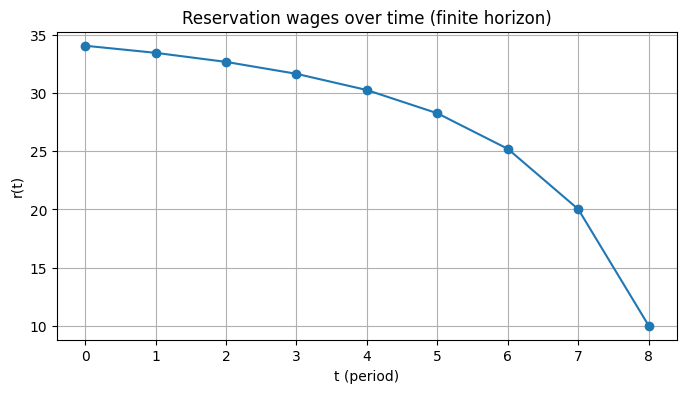

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def make_wage_distribution(w_min=10, w_max=60, alpha=100, beta_shape=50):
    wages = np.arange(w_min, w_max+1)
    # Map wage w in [w_min, w_max] to x in [0, 1].
    # E.g. x = (w - w_min)/(w_max - w_min)
    x_vals = (wages - w_min)/(w_max - w_min)
    
    # Evaluate Beta(alpha, beta_shape) pdf at each x
    pdf_vals = beta.pdf(x_vals, alpha, beta_shape)
    pmf = pdf_vals / pdf_vals.sum()
    
    return wages, pmf

def solve_finite_horizon_job_search(
    T=8,    # last period is 8, so total of 9 periods: t=0..8
    c=10,   # unemployment benefit
    beta_disc=0.9,
    wages=None,
    pmf=None
):

    if wages is None or pmf is None:
        
        wages, pmf = make_wage_distribution()
    
    # Precompute sum_{tau=0 to T-t} beta^tau for each t:
    # This factor is how many times log(w) gets counted if you accept in period t
    G = np.array([sum(beta_disc**k for k in range(T-t+1)) for t in range(T+1)])
    
    V = np.zeros(T+1)  
    r = np.zeros(T+1)  
    
    # 1) Last period T
    V[T] = np.sum(np.maximum(np.log(wages), np.log(c)) * pmf)
    # r[T]: solve G[T]*ln(r[T]) = ln(c)
    # because at T+1 there's no future, so V[T+1] = 0 in that formula
    # G[T] = sum_{k=0}^0 beta^k = 1
    r[T] = np.exp( (np.log(c) + beta_disc*0.0) / G[T] )
    
    # 2) Work backward t = T-1 down to 0
    for t in reversed(range(T)):
        # V[t] = sum_w p(w)* max( G[t]*ln(w), ln(c) + beta_disc*V[t+1] )
        accept_vals = G[t] * np.log(wages) 
        reject_val  = np.log(c) + beta_disc * V[t+1]
        
        inside_max = np.maximum(accept_vals, reject_val)
        V[t] = np.sum(inside_max * pmf)
        
        # reservation wage r[t] solves
        #     G[t]*ln(r[t]) = ln(c) + beta_disc*V[t+1]
        r[t] = np.exp((np.log(c) + beta_disc * V[t+1]) / G[t])
    
    return V, r, wages


if __name__ == "__main__":
    # Solve for T=8
    T = 8
    V, r, wages = solve_finite_horizon_job_search(T=T, c=10, beta_disc=0.9)
    
    print("Period |  Reservation Wage  | Value of Search")
    for t in range(T+1):
        print(f"{t:5d} | {r[t]:18.4f} | {V[t]:14.4f}")
    
    # Plot reservation wages over time
    plt.figure(figsize=(8,4))
    plt.plot(range(T+1), r, marker="o")
    plt.title("Reservation wages over time (finite horizon)")
    plt.xlabel("t (period)")
    plt.ylabel("r(t)")
    plt.grid(True)
    plt.show()


# 3 Market Equilibrium

Final (p1,p2) at lam=1: (9.8199, 3.4882)


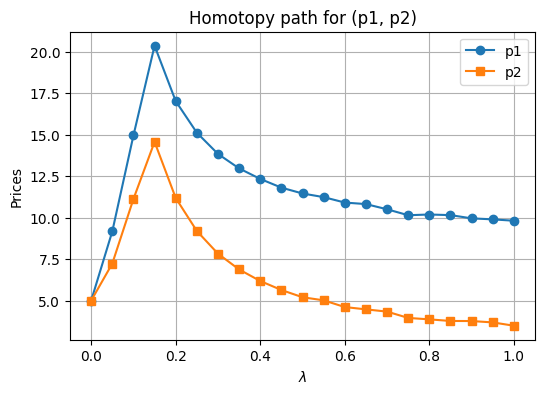

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

# 1) Demand and supply functions
def D1(p1, p2):
    return 100 - 2.0*p1 + 0.5*(p2**2)

def S1(p1):
    return 20 + 0.1*(p1**2)

def D2(p1, p2):
    return 80 - 3.0*p2 + 0.2*(p1**2)

def S2(p2):
    return 30 + 0.05*(p2**2)

# 2) Homotopy system H = (H1, H2).
#    p = (p1, p2), lam in [0,1].
#    p1_ref, p2_ref are reference prices where H(...)=0 at lam=0.
p1_ref = 5.0
p2_ref = 5.0

def H(p, lam):
    p1, p2 = p
    H1 = lam*( S1(p1) - D1(p1,p2) ) + (1 - lam)*( p1 - p1_ref )
    H2 = lam*( S2(p2) - D2(p1,p2) ) + (1 - lam)*( p2 - p2_ref )
    return np.array([H1, H2])

def solve_for_prices(lam, p_init):
    sol = root(lambda p: H(p, lam), p_init, method='hybr')
    return sol.x


def main():
    # 3) Trace out solutions as lam goes from 0 to 1
    lam_values = np.linspace(0, 1, 21) 
    p_current = np.array([p1_ref, p2_ref])
    
    solutions = []
    
    for lam in lam_values:
        p_current = solve_for_prices(lam, p_current)
        solutions.append(p_current)
    
    solutions = np.array(solutions)
    p1_vals = solutions[:,0]
    p2_vals = solutions[:,1]
    
 
    print(f"Final (p1,p2) at lam=1: ({p1_vals[-1]:.4f}, {p2_vals[-1]:.4f})")

    plt.figure(figsize=(6,4))
    plt.plot(lam_values, p1_vals, 'o-', label='p1')
    plt.plot(lam_values, p2_vals, 's-', label='p2')
    plt.xlabel(r'$\lambda$')
    plt.ylabel('Prices')
    plt.title('Homotopy path for (p1, p2)')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
